In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as nnf
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torchsummary import summary

import lightning as L
from lightning.pytorch.callbacks import ModelSummary
from lightning.pytorch.utilities import grad_norm

from tqdm import tqdm

import matplotlib.pyplot as plt

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
# class Encoder(nn.Module):

#     def __init__(self, latent_dim):
#         super(Encoder, self).__init__()

#         self.latent_dim = latent_dim

#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
#             nn.Flatten()
#         )
        
#         # Latent space representation (mean and log variance)
#         self.fc_mean = nn.Linear(64 * 4 * 4, latent_dim)
#         self.fc_log_var = nn.Linear(64 * 4 * 4, latent_dim)

#     def forward(self, x):
#         x = self.encoder(x)        
#         mean = self.fc_mean(x)
#         log_var = self.fc_log_var(x)

#         return mean, log_var
    
# class Decoder(nn.Module):
        
#     def __init__(self, latent_dim):
#         super(Decoder, self).__init__()

#         self.latent_dim = latent_dim

#         self.fc_decode = nn.Linear(latent_dim, 64 * 4 * 4)
#         self.decoder = nn.Sequential(
#             nn.Unflatten(1, (64, 4, 4)),
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(32),
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),
#             nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
#             nn.Sigmoid()  # To ensure pixel values between 0 and 1
#         )

#     def forward(self, x):
#         x = self.fc_decode(x)
#         x = self.decoder(x)

#         return x

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim, hidden_dims=None):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_channels = input_channels

        if hidden_dims is None:
            hidden_dims = [32, 128]#, 256, 512]

        # Encoder
        modules = []
        in_channels = input_channels
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*16, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*16, latent_dim)
    
    def forward(self, LR):
        z = self.encoder(LR)
        z = torch.flatten(z, start_dim=1)
        mu = self.fc_mu(z)
        log_var = self.fc_var(z)
        return [mu, log_var]

In [4]:
class Decoder(nn.Module):
    def __init__(self, input_channels, latent_dim, hidden_dims=None):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.input_channels = input_channels

        if hidden_dims is None:
            hidden_dims = [32, 64, 128]
        hidden_dims.reverse()

        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[0] * 16)

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                        hidden_dims[i + 1],
                                        kernel_size=3,
                                        stride=2,
                                        padding=1,
                                        output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1],
                                hidden_dims[-1],
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=input_channels,
                        kernel_size=3, padding=1),
            nn.Sigmoid())
        
    def forward(self, z):
        SR = self.decoder_input(z)
        SR = SR.view(-1, 128, 4, 4)
        SR = self.decoder(SR)
        SR = self.final_layer(SR)
        return SR

In [5]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        self.loss = []
        self.lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var*epsilon
        return z

    def forward(self, LR):
        mean, log_var = self.Encoder(LR)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        SR = self.Decoder(z)

        return SR, mean, log_var

In [6]:
class CIFAR_SR(Dataset):    
    def __init__(self, scale_factor=0.5, split="train", download=True):
        self.scale_factor = scale_factor

        match split:
            case "train":
                train = True
            case "test":
                train = False
            case other:
                raise NotImplementedError(f"Unrecognized split: '{other}'")
        
        transform = transforms.Compose([
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.ToTensor(),
        ])
        self.dataset = datasets.CIFAR10(root="./data", train=train, transform=transform, download=download)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        HR, _ = self.dataset[index]
        LR = nnf.interpolate(HR.unsqueeze(0), scale_factor=self.scale_factor, mode='bicubic', align_corners=False)[0]
        LR = (LR - LR.min()) / (LR.max() - LR.min())
        return HR.to(DEVICE), LR.to(DEVICE)
    
    def get_samples(self, n_samples):
        HR_samples = []
        LR_samples = []
        for i in range(n_samples):
            ind = np.random.randint(len(self))
            HR, LR = self[ind]
            HR_samples.append(HR)
            LR_samples.append(LR)
        return torch.stack(HR_samples, dim=0), torch.stack(LR_samples, dim=0)

In [7]:
x_dim = 32
channels = 3

scale_factor = 2
x_inp_dim  = int(x_dim / scale_factor)


# # hidden_dim = 500
latent_dim = 50

# lr = 1e-3
epochs = 200
batch_size = 2048
batch_size_test = 128

train_dataset = CIFAR_SR(split="train")
test_dataset = CIFAR_SR(split="test")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [8]:
encoder = Encoder(input_channels=channels, latent_dim=latent_dim)
decoder = Decoder(input_channels=channels, latent_dim=latent_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [9]:
summary(model, input_size=(channels, x_inp_dim, x_inp_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 32, 8, 8]             896
       BatchNorm2d-2             [-1, 32, 8, 8]              64
         LeakyReLU-3             [-1, 32, 8, 8]               0
            Conv2d-4            [-1, 128, 4, 4]          36,992
       BatchNorm2d-5            [-1, 128, 4, 4]             256
         LeakyReLU-6            [-1, 128, 4, 4]               0
            Linear-7                   [-1, 50]         102,450
            Linear-8                   [-1, 50]         102,450
           Encoder-9       [[-1, 50], [-1, 50]]               0
           Linear-10                 [-1, 2048]         104,448
  ConvTranspose2d-11             [-1, 64, 8, 8]          73,792
      BatchNorm2d-12             [-1, 64, 8, 8]             128
        LeakyReLU-13             [-1, 64, 8, 8]               0
  ConvTranspose2d-14           [-1, 32,

In [10]:
def loss_function(x, x_hat, mean, log_var, lpips):
    reproduction_loss = lpips(x_hat, x)
    KLD = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return (reproduction_loss + KLD) / x.size(0)

optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold=0.0001)

In [11]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        HR, LR = batch

        SR, mean, log_var = model(LR)
        loss = loss_function(HR, SR, mean, log_var, model.lpips)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print("\tEpoch", epoch, "complete!", "\tAverage Loss: ", overall_loss)

    model.loss.append(overall_loss)
    scheduler.step(overall_loss)

print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss)
print("Finish!!")

Start training VAE...
	Epoch 0 complete! 	Average Loss:  69.1189478635788
	Epoch 10 complete! 	Average Loss:  4.030557185411453
	Epoch 20 complete! 	Average Loss:  1.6564899310469627
	Epoch 30 complete! 	Average Loss:  0.9436921030282974
	Epoch 40 complete! 	Average Loss:  0.6199117843061686
	Epoch 50 complete! 	Average Loss:  0.4409487098455429
	Epoch 60 complete! 	Average Loss:  0.3298673704266548
	Epoch 70 complete! 	Average Loss:  0.25652589835226536
	Epoch 80 complete! 	Average Loss:  0.20246714539825916
	Epoch 90 complete! 	Average Loss:  0.16662563383579254
	Epoch 100 complete! 	Average Loss:  0.1366220721974969
	Epoch 110 complete! 	Average Loss:  0.11565647507086396
	Epoch 120 complete! 	Average Loss:  0.09684982313774526
	Epoch 130 complete! 	Average Loss:  0.08587384666316211
	Epoch 140 complete! 	Average Loss:  0.07245965488255024
	Epoch 150 complete! 	Average Loss:  0.06370270764455199
	Epoch 160 complete! 	Average Loss:  0.0563143091276288
	Epoch 170 complete! 	Average Lo

[]

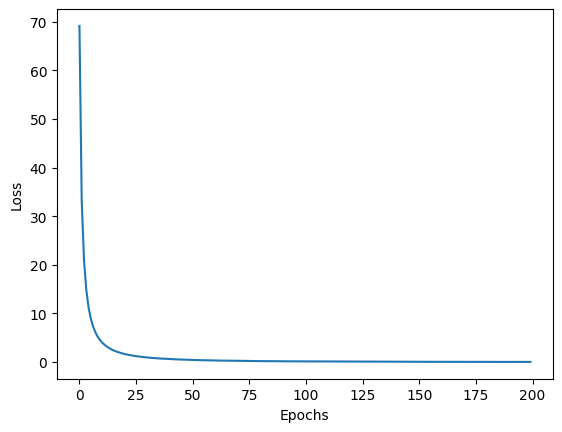

In [12]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.yscale('log')
plt.plot()

In [13]:
def show_image(x, x_inp, x_hat, n):
    # x = x.view(batch_size_test, channels, x_dim, x_dim)
    # x_inp = x_inp.view(batch_size_test, channels, x_inp_dim, x_inp_dim)
    # x_hat = x_hat.view(batch_size_test, channels, x_dim, x_dim)
    x_hat = x_hat.detach().cpu()

    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        axs[0, i].imshow(x[i].permute(1, 2, 0).cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(x_inp[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(x_hat[i].permute(1, 2, 0).cpu().numpy())
        axs[2, i].axis('off')

In [14]:
x, x_inp = test_dataset.get_samples(64)
x = x.to(DEVICE)
x_inp = x_inp.to(DEVICE)
x_hat, _, _ = model(x_inp)

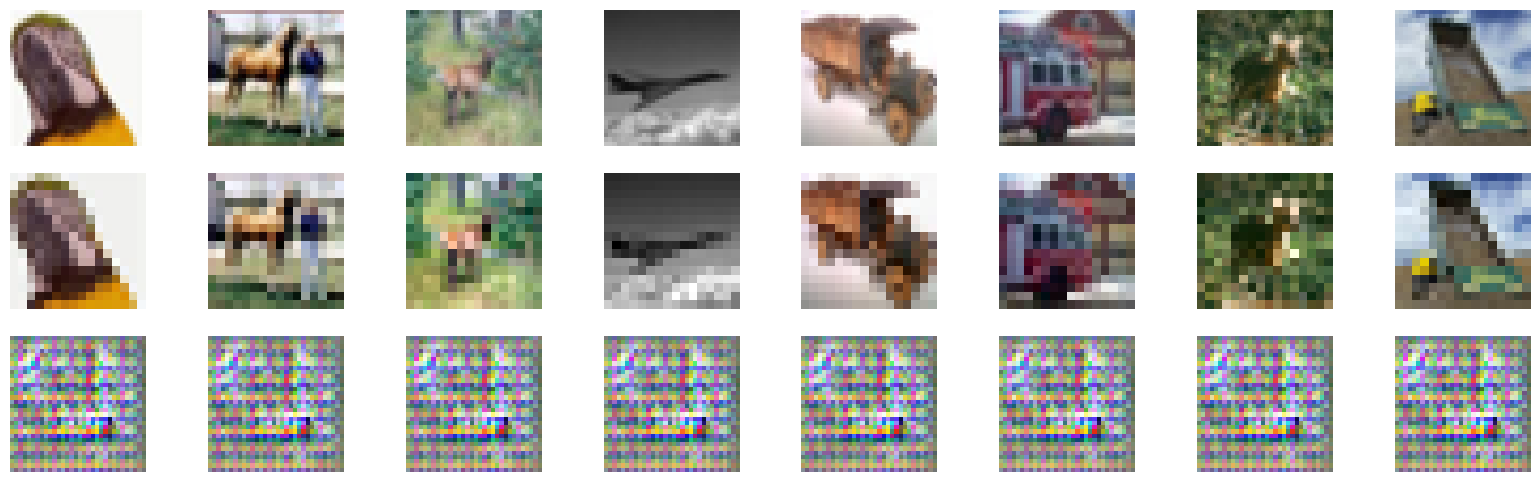

In [15]:
show_image(x, x_inp, x_hat, 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005732997..1.0323642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005732997..1.0323642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005732997..1.0323642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005732997..1.0323642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005732997..1.0323642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005732997..1.0323642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got rang

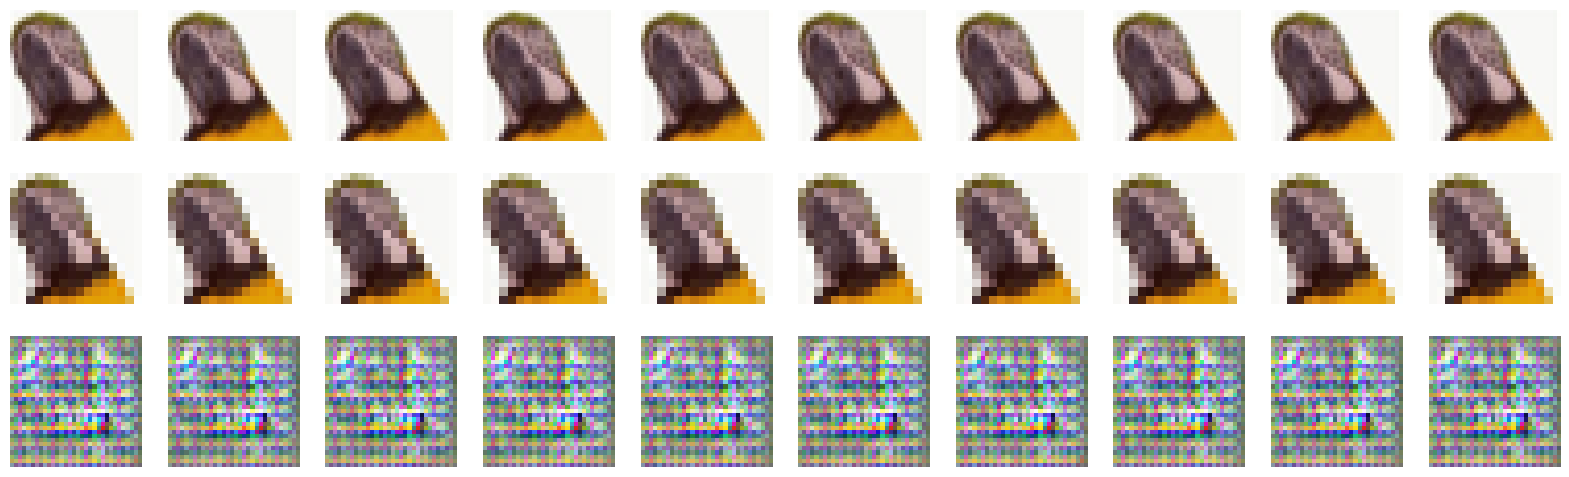

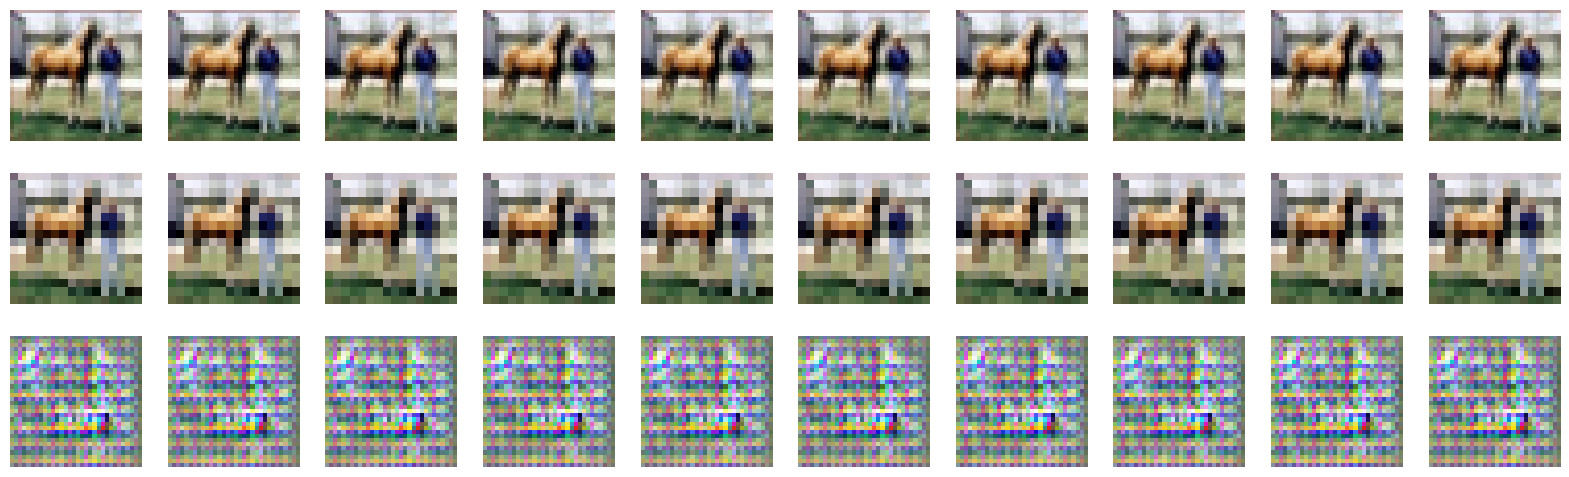

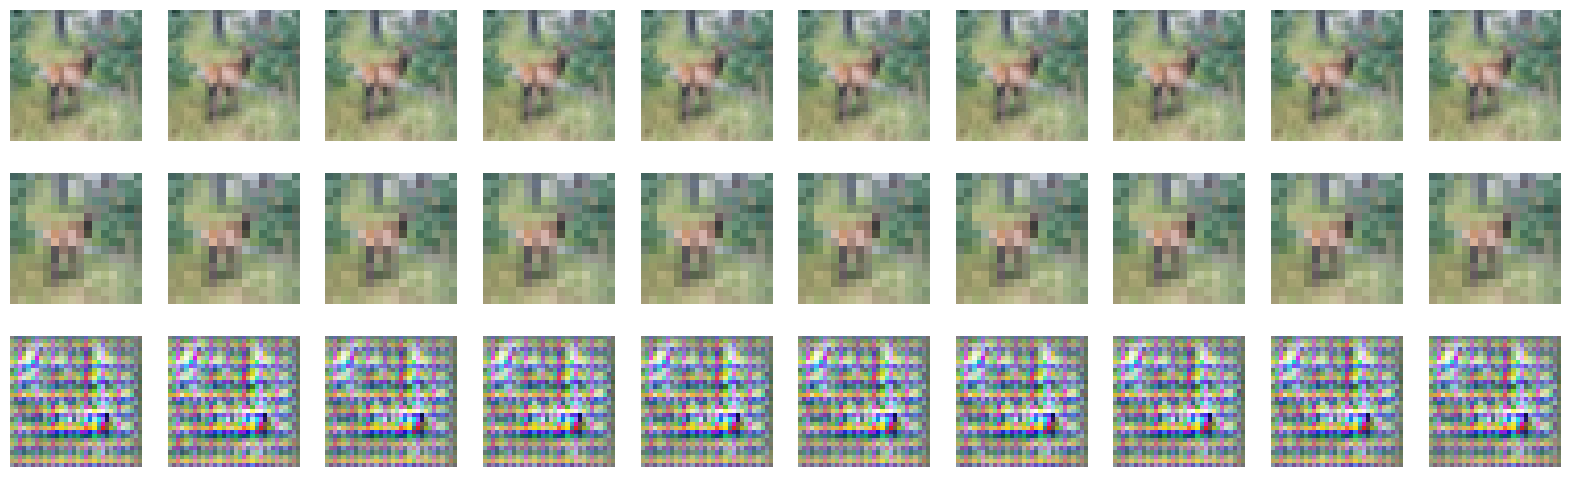

In [16]:
n_samp = 3

for i in range(n_samp):
    reference = x[i].view(1, channels, x_dim, x_dim)
    reference = reference.repeat(batch_size_test, 1, 1, 1)
    reference_inp = torch.nn.functional.interpolate(reference, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
    
    samples = model.forward(reference_inp)[0].detach().cpu()

    show_image(reference, reference_inp, samples, 10)
    

In [17]:
# save model
torch.save(model.state_dict(), "CIFAR11.pth")

In [10]:
model.load_state_dict(torch.load("CIFAR11.pth"))

<All keys matched successfully>

In [18]:
from piq import psnr, ssim, brisque, LPIPS

def validation_scores(model, HR, LR):
    SR, _, _ = model(LR)

    psnr_val = psnr(HR, SR, data_range=1.0)

    ssim_val = ssim(HR, SR, data_range=1.0, reduction='none')

    lpips = LPIPS()
    lpips_val = lpips(HR, SR)

    brisque_val = brisque(SR)

    HR_downsampled = nnf.interpolate(HR, size=(LR.size(2), LR.size(3)), mode='bicubic', align_corners=False)
    HR_downsampled = (HR_downsampled - HR_downsampled.min()) / (HR_downsampled.max() - HR_downsampled.min())

    psnr_consistency_val = psnr(LR, HR_downsampled, data_range=1.0)

    mse_diversity_val = 0
    lpips_diversity_val = 0
    n_samples = 16
    for i in range(n_samples):
        LR_input = LR[i].unsqueeze(0)
        LR_input = LR_input.repeat(32, 1, 1, 1)
        HR_reference = HR[i].unsqueeze(0)
        HR_reference = HR_reference.repeat(32, 1, 1, 1)
        SR, _, _ = model(LR_input)
        mse_diversity_val += nn.functional.mse_loss(HR_reference, SR, reduction='mean')
        lpips_diversity_val += lpips(HR_reference, SR)
    mse_diversity_val /= n_samples
    lpips_diversity_val /= n_samples

    return psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val

In [14]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, x, x_inp)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val.mean())
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

/home/max/miniconda3/envs/ML/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/max/miniconda3/envs/ML/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PSNR: tensor(18.0627, device='cuda:0', grad_fn=<MeanBackward1>)
SSIM: tensor(0.4778, device='cuda:0', grad_fn=<MeanBackward0>)
LPIPS: tensor(0.5092, device='cuda:0', grad_fn=<MeanBackward1>)
BRISQUE: tensor(84.0476, device='cuda:0', grad_fn=<MeanBackward1>)
PSNR Consistency: tensor(26.3310, device='cuda:0')
MSE Diversity: tensor(0.0392, device='cuda:0', grad_fn=<DivBackward0>)
LPIPS Diversity: tensor(0.5926, device='cuda:0', grad_fn=<DivBackward0>)


In [16]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, x, x_inp)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val.mean())
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

/home/max/miniconda3/envs/ML/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/max/miniconda3/envs/ML/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


PSNR: tensor(18.0624, device='cuda:0', grad_fn=<MeanBackward1>)
SSIM: tensor(0.4821, device='cuda:0', grad_fn=<MeanBackward0>)
LPIPS: tensor(0.5145, device='cuda:0', grad_fn=<MeanBackward1>)
BRISQUE: tensor(80.7182, device='cuda:0', grad_fn=<MeanBackward1>)
PSNR Consistency: tensor(25.2936, device='cuda:0')
MSE Diversity: tensor(0.0490, device='cuda:0', grad_fn=<DivBackward0>)
LPIPS Diversity: tensor(0.5960, device='cuda:0', grad_fn=<DivBackward0>)
